In [1]:
import sys
import pickle
import torch
import control as ct
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
from numpy.linalg import eig
import matplotlib.pyplot as plt
import matplotlib as mpl  
import torch.optim as optim
from torch.utils.data import random_split
import torch.multiprocessing as mp
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from torch.utils.data import Dataset, DataLoader


# ***Pendulum Dynamics and RK4 Functions***

In [2]:
# function to output the state space dynamics of the orbit
def pendfunc(t,x,u):
    g = 9.81  # gravity
    L = 5  # length     
    fdyn = np.array([x[1], -g*np.sin(x[0])/L+u[0]])
    return fdyn


# runge-kutta fourth-order numerical integration
def rk4(func, tk, _yk, uk, _dt, **kwargs):
    """
    single-step fourth-order numerical integration (RK4) method
    func: system of first order ODEs
    tk: current time step
    _yk: current state vector [y1, y2, y3, ...]
    _dt: discrete time step size
    **kwargs: additional parameters for ODE system
    returns: y evaluated at time k+1
    """

    # evaluate derivative at several stages within time interval
    f1 = func(tk, _yk,uk, **kwargs)
    f2 = func(tk + _dt / 2, _yk + (f1 * (_dt / 2)),uk, **kwargs)
    f3 = func(tk + _dt / 2, _yk + (f2 * (_dt / 2)),uk, **kwargs)
    f4 = func(tk + _dt, _yk + (f3 * _dt),uk, **kwargs)

    # return an average of the derivative over tk, tk + dt
    return np.array(_yk + (_dt / 6) * (f1 + (2 * f2) + (2 * f3) + f4))

# ***Load Data***

In [3]:
# listing the GPU as device variable
device = torch.device("cuda:0")

# importing training data from the saved file
data_x = torch.load('data_x_c_noisy.pt').to(torch.float32)
data_y = torch.load('data_y_c_noisy.pt').to(torch.float32)
data_y2 = torch.load('data_y2_c_noisy.pt').to(torch.float32)
data_u = torch.load('data_u_c_noisy.pt').to(torch.float32)

# loading the data-specific variables
with open('pendulum_variables_data.pkl', 'rb') as f:
    tf,dp,dt,nx,m,predict_time = pickle.load(f)

# train-test split for evaluation of the model
loader = DataLoader(list(zip(data_x, data_y, data_y2, data_u)), shuffle=True, batch_size=4096)

Text(0.5, 1.0, 'Sample Training Data of $\\Theta$')

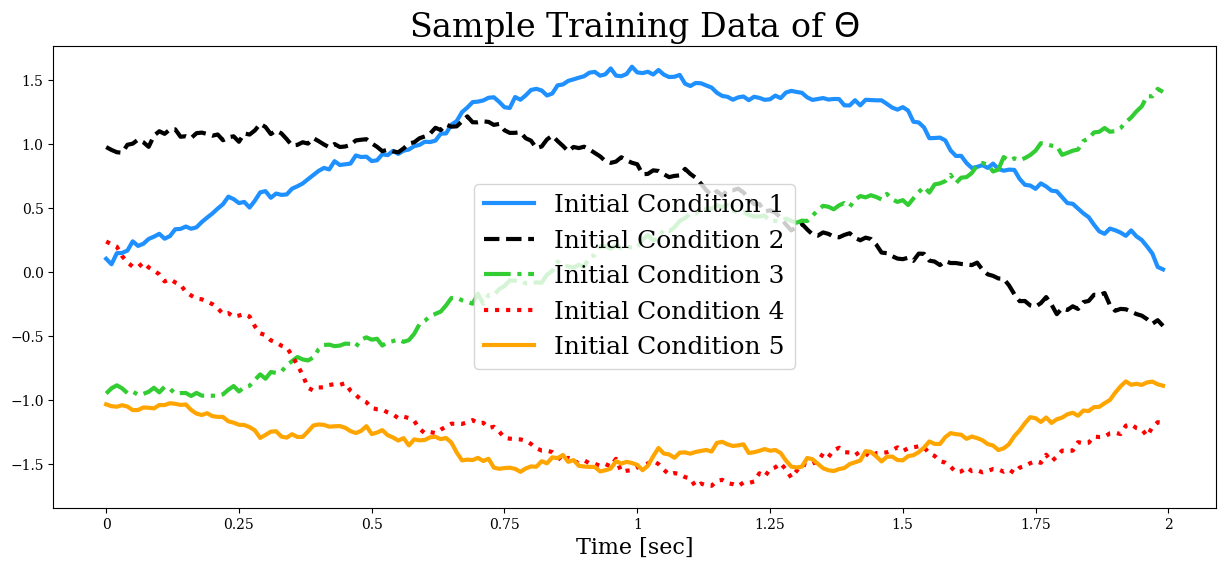

In [4]:
# Plotting a sample of the training data
mpl.rc('font',family='Serif')
plt.figure(figsize = (15, 6))
ax = plt.axes()
colour = ['dodgerblue', 'black', 'limegreen', 'red', 'orange']
line = ['-', '--', '-.', ':', '-']
for i in range(5):
    x = data_x[i,:,0].cpu() # current state
    ax.plot(x, linestyle = line[i], color = colour[i], label = 'Initial Condition %s' % int(i+1), linewidth=3)
    ax.legend(fontsize=18)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.xticks([0, 25, 50, 75, 100, 125, 150, 175, 200], [0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2])
plt.xlabel("Time [sec]", fontsize=16)
plt.ylabel("", fontsize=16)
plt.title("Sample Training Data of $\Theta$", fontsize=24)

# ***Neural Network Definition and Training***

In [5]:
# defining the hyper parameters for the Neural Network
input_size = nx 
lifted_space = 2
hidden_size = 6
learning_rate = 0.0001
P = torch.cat((torch.eye(nx),torch.zeros(nx,lifted_space)),1).to(device)

# creating the encoder Neural Network model 
class Encoder(nn.Module):
    def __init__(self, input_size, lifted_space):
        super(Encoder, self).__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_size, hidden_size),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_size, lifted_space)

        )

    # weight initialisation
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    # the encoding step
    def forward(self, x):
          encoded = self.encoder(x)
          return encoded

# creating the model variable
modelen = Encoder(input_size, lifted_space).to(device)
print(modelen)

criterion = torch.nn.MSELoss().to(device) # mean squared loss criterion 
optimizer = optim.Adam(list(modelen.parameters()), lr=learning_rate, weight_decay=1e-5) # model optimizer

Encoder(
  (encoder): Sequential(
    (0): Linear(in_features=2, out_features=6, bias=True)
    (1): SELU()
    (2): Linear(in_features=6, out_features=6, bias=True)
    (3): SELU()
    (4): Linear(in_features=6, out_features=6, bias=True)
    (5): SELU()
    (6): Linear(in_features=6, out_features=6, bias=True)
    (7): SELU()
    (8): Linear(in_features=6, out_features=6, bias=True)
    (9): SELU()
    (10): Linear(in_features=6, out_features=6, bias=True)
    (11): SELU()
    (12): Linear(in_features=6, out_features=6, bias=True)
    (13): SELU()
    (14): Linear(in_features=6, out_features=6, bias=True)
    (15): SELU()
    (16): Linear(in_features=6, out_features=2, bias=True)
  )
)


In [7]:
# Training hyper parameters 
num_epochs = 10000
i = 0
Loss = []
Loss_prev = 1

for epoch in range(num_epochs):
    for part_x, part_y, part_y2, part_u in loader:

        # # splitting the whole dataset into batches
        # part_x = data_x[batch*batch_size:batch*batch_size+(batch_size-1)]
        # part_y = data_y[batch*batch_size:batch*batch_size+(batch_size-1)]
        # part_u = data_u[batch*batch_size:batch*batch_size+(batch_size-1)]

        # # reshaping 3D dataset into 2D to pass the whole batch through the NN
        # part_x = part_x.reshape([int(len(part_x)*dp),nx]).to(device)
        # part_y = part_y.reshape([int(len(part_y)*dp),nx]).to(device)
        # part_u = part_u.reshape([int(len(part_u)*dp),m]).to(device)

        # # transposing the batch to fit the NN structure
        # transpose_y_train  = torch.transpose(part_y,0,1).to(device)
        # transpose_x_train  = torch.transpose(part_x,0,1).to(device)
        # transpose_u_train  = torch.transpose(part_u,0,1).to(device)

        # phi_k_plus_one = torch.transpose(modelen(part_y),0,1).to(device) # observables for one step ahead in time
        # phi_k = torch.transpose(modelen(part_x),0,1).to(device) # observables at current time step
        
        # K_phi_k_plus_one = torch.cat((transpose_y_train,phi_k_plus_one),0) # adding the original states to the observables
        # K_phi_k = torch.cat((transpose_x_train,phi_k),0) # adding the original states to the observables

        part_x = part_x.reshape([int(len(part_x)*(dp)),nx]).to(device) # reshaping to stack all initial conditions on top of each other
        part_y = part_y.reshape([int(len(part_y)*(dp)),nx]).to(device) # reshaping to stack all initial conditions on top of each other
        # part_y2 = part_y2.reshape([int(len(part_y2)*(dp)),nx]).to(device) # reshaping to stack all initial conditions on top of each other
        part_u = part_u.reshape([int(len(part_u)*(dp)),m]).to(device) # reshaping to stack all initial control on top of each other
        transpose_y_train  = torch.transpose(part_y,0,1).to(device)    # transpose to fit the model
        # transpose_y2_train  = torch.transpose(part_y2,0,1).to(device)    # transpose to fit the model
        transpose_x_train  = torch.transpose(part_x,0,1).to(device)    # transpose to fit the model
        transpose_u_train  = torch.transpose(part_u,0,1).to(device)    # transpose to fit the model

        phi_k = torch.transpose(modelen(part_x.to(device)),0,1).to(device)          # encoded x data
        K_phi_k = torch.cat((transpose_x_train,phi_k),0).to(device)                   # adding the original states to the encoded x data

        phi_k_plus_one = torch.transpose(modelen(part_y.to(device)),0,1).to(device) # encoded y data
        K_phi_k_plus_one = torch.cat((transpose_y_train,phi_k_plus_one),0).to(device) # adding the original states to the encoded y data
    
        # finding K and B matrices with EDMD
        W = torch.cat((K_phi_k,transpose_u_train),0)  
        V = K_phi_k_plus_one

        Vwt = torch.matmul(V,torch.transpose((W),0,1))
        Wwt = torch.matmul(W,torch.transpose((W),0,1))
        KB = torch.matmul(Vwt,torch.pinverse(Wwt))

        K = KB[:,0:-m]
        B = KB[:,-m:]

        # next time step prediciton with linear Koopman operator
        K_phi_plus_one = torch.matmul(K,K_phi_k)+torch.matmul(B,transpose_u_train)
        x_plus_one = torch.matmul(P,K_phi_plus_one)
        
        # Forward pass and loss calculation
        outputen_without_states = modelen(part_y) # output of just the encoder 
        outputen = torch.transpose(torch.cat((part_y,outputen_without_states),1),0,1) # add original states as the observables to the actual observables 

        # prediction loss        
        # loss_2 = criterion(x_plus_one, transpose_y2_train)
            
        #~~~~~~~~~~~~~~~~~ Multiple Time Step Predicition Loss ~~~~~~~~~~~~~~~~~#
        for l in range(predict_time):
            next_phi = torch.matmul(K,K_phi_k) + torch.matmul(B,transpose_u_train) # K: This is the linear operation. 
            next_state = torch.matmul(P,next_phi) # extracting the next state
            next_state_encoded = modelen(torch.transpose(next_state,0,1).to(device)) # stacking original states on 
            K_phi_k = torch.transpose(torch.cat((torch.transpose(next_state,0,1).to(device),next_state_encoded),1),0,1)

        loss_x = next_state
        loss_y = transpose_y_train

        # Forward pass and loss calculation
        loss_1 = criterion(loss_x, loss_y) # Koopman loss (finds K) EDMD loss


        loss_1_lambda = 0.8

        loss_2=0
        # loss_x2 = torch.matmul(K,K_phi_k)
        # loss_y2 = K_phi_k_plus_one
        # loss_2 = criterion(loss_x2, loss_y2)
        loss_2_lambda = 1
        
        l1_lambda = 0.04
        l1_regularisation = sum(p.norm().sum()
                for p in modelen.parameters())
        loss_L1 = l1_lambda * l1_regularisation

        l2_lambda = 0.01
        l2_regularisation = sum(p.pow(2.0).sum()
                for p in modelen.parameters())
        loss_L2 = l2_lambda * l2_regularisation

        loss = loss_1_lambda*loss_1 + loss_2_lambda*loss_2 + loss_L1 + loss_L2
        
        # Backward and optimize
        optimizer.zero_grad() # find the gradients.
        loss.backward(retain_graph=True)       # needed for multiple loss functions.  Not need for one loss function. We have 2.
        optimizer.step()      # updates the weights for the each parameter.

        # storing the K and PK values and model of the best model trained so far
        if loss.item() < Loss_prev or (iter == 0 and epoch == 0):
            best_model = modelen
            torch.save(modelen, '2BPbest-model.pt')
            K_best = K
            # B_best = B
            Loss_prev = loss.item()
        modelen = best_model

                # logging of losses
        if (i+1) % 100 == 0:
            print (f'Epoch: [{epoch+1}/{num_epochs}],  Loss: {loss.item():.15f},   L1 Loss: {loss_L1}, L2 Loss: {loss_L2}')
        i = i+1
        Loss.append(loss.item())

    # storing the best K and PK to a data file
    with open('2BPobjs.pkl', 'wb') as f:
        # pickle.dump([B_best, K_best], f)
        pickle.dump(K_best, f)

Epoch: [50/10000],  Loss: 0.846147835254669,   L1 Loss: 0.6587645411491394, L2 Loss: 0.17988570034503937
Epoch: [100/10000],  Loss: 0.845930933952332,   L1 Loss: 0.6585506796836853, L2 Loss: 0.17975671589374542
Epoch: [150/10000],  Loss: 0.845835387706757,   L1 Loss: 0.6585571765899658, L2 Loss: 0.1797722578048706
Epoch: [200/10000],  Loss: 0.845829606056213,   L1 Loss: 0.658546507358551, L2 Loss: 0.17974773049354553
Epoch: [250/10000],  Loss: 0.845623612403870,   L1 Loss: 0.6583494544029236, L2 Loss: 0.1796404868364334
Epoch: [300/10000],  Loss: 0.845290064811707,   L1 Loss: 0.6582144498825073, L2 Loss: 0.1795690357685089
Epoch: [350/10000],  Loss: 0.845393657684326,   L1 Loss: 0.6582111120223999, L2 Loss: 0.17955560982227325
Epoch: [400/10000],  Loss: 0.845303773880005,   L1 Loss: 0.658218502998352, L2 Loss: 0.17955970764160156
Epoch: [450/10000],  Loss: 0.844966709613800,   L1 Loss: 0.6580026149749756, L2 Loss: 0.17944283783435822
Epoch: [500/10000],  Loss: 0.844584226608276,   L1 L

In [19]:
Loss = torch.load("Training_Loss.pt")

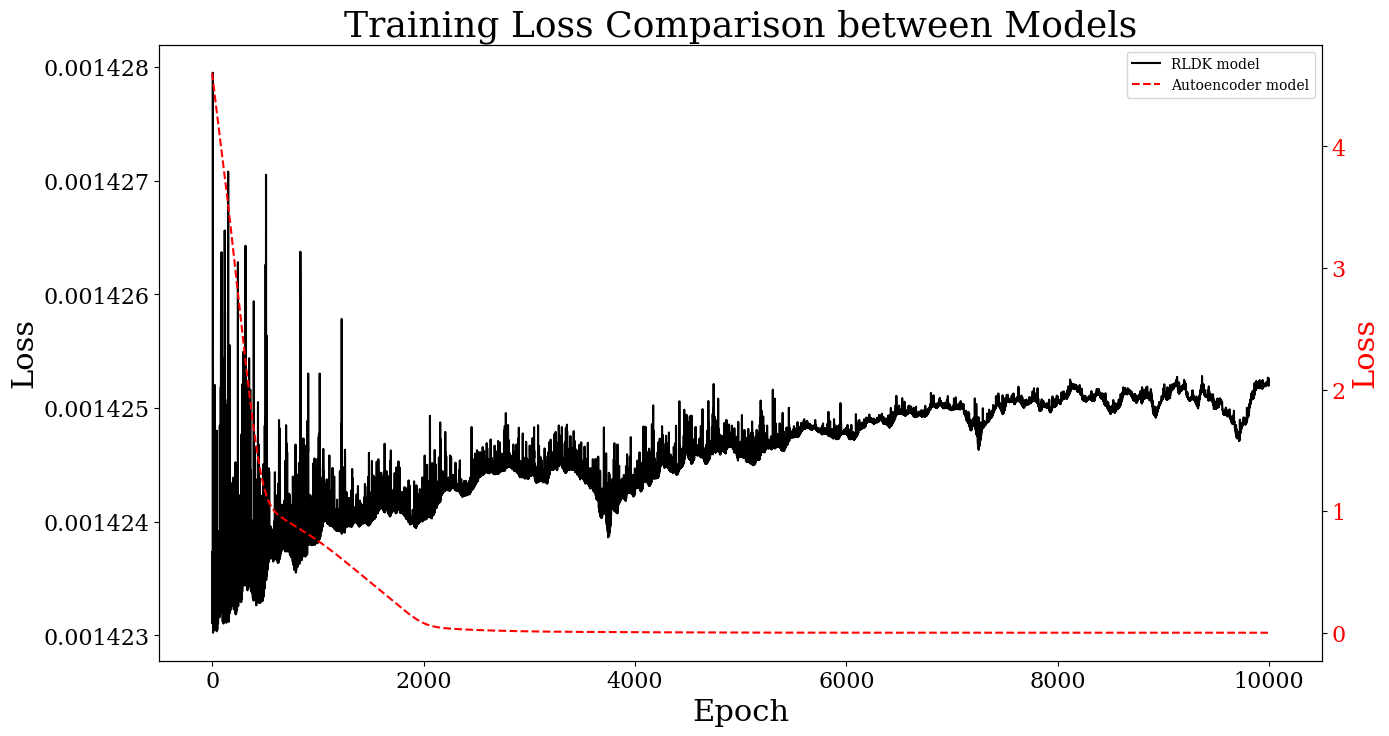

In [22]:
# importing dataset from Autoencoder model
with open('autoencoder_loss.pkl', 'rb') as f:
    auto_loss = pickle.load(f)

# plotting training loss
fig, ax1 = plt.subplots(figsize = (15, 8))
lns1 = ax1.plot(Loss, color='black', label = 'RLDK model')
ax1.set_xlabel("Epoch", fontsize = 22)
ax1.set_ylabel('Loss', fontsize = 22)
ax1.set_title("Training Loss Comparison between Models", fontsize=26)

ax2 = ax1.twinx()
lns2 = ax2.plot(auto_loss, linestyle='--', color='red', label = 'Autoencoder model')
ax2.set_ylabel('Loss', color = 'red', fontsize = 22)
ax2.tick_params(axis='y', labelcolor='red')

fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

# # subregion of the original plot
# x1, x2, y1, y2 = 5000, 10000, 0.00012, 0.0015
# axins = inset_axes(ax2, 4,3, loc='right')
# axins.plot(auto_loss, linestyle='--', color='red')
# axins.set_xlim(x1, x2)
# axins.set_ylim(y1, y2)
# plt.xticks(visible=False)
# plt.yticks(fontsize=12, color='red')
# mark_inset(ax2, axins, loc1=3, loc2=4, fc="none", ec="0.5")
# plt.draw()
# plt.show()

## *Load Best Model*

In [9]:
# loading the best NN model and Koopman matrices
modelen = torch.load('bestpen-model (used in paper).pt')
with open('pend_objs (used in paper).pkl', 'rb') as f:
    B_best, K_best = pickle.load(f)

# ***One-Step Prediction Test Case***

Text(0.5, 1.0, '$\\dot{\\Theta}$')

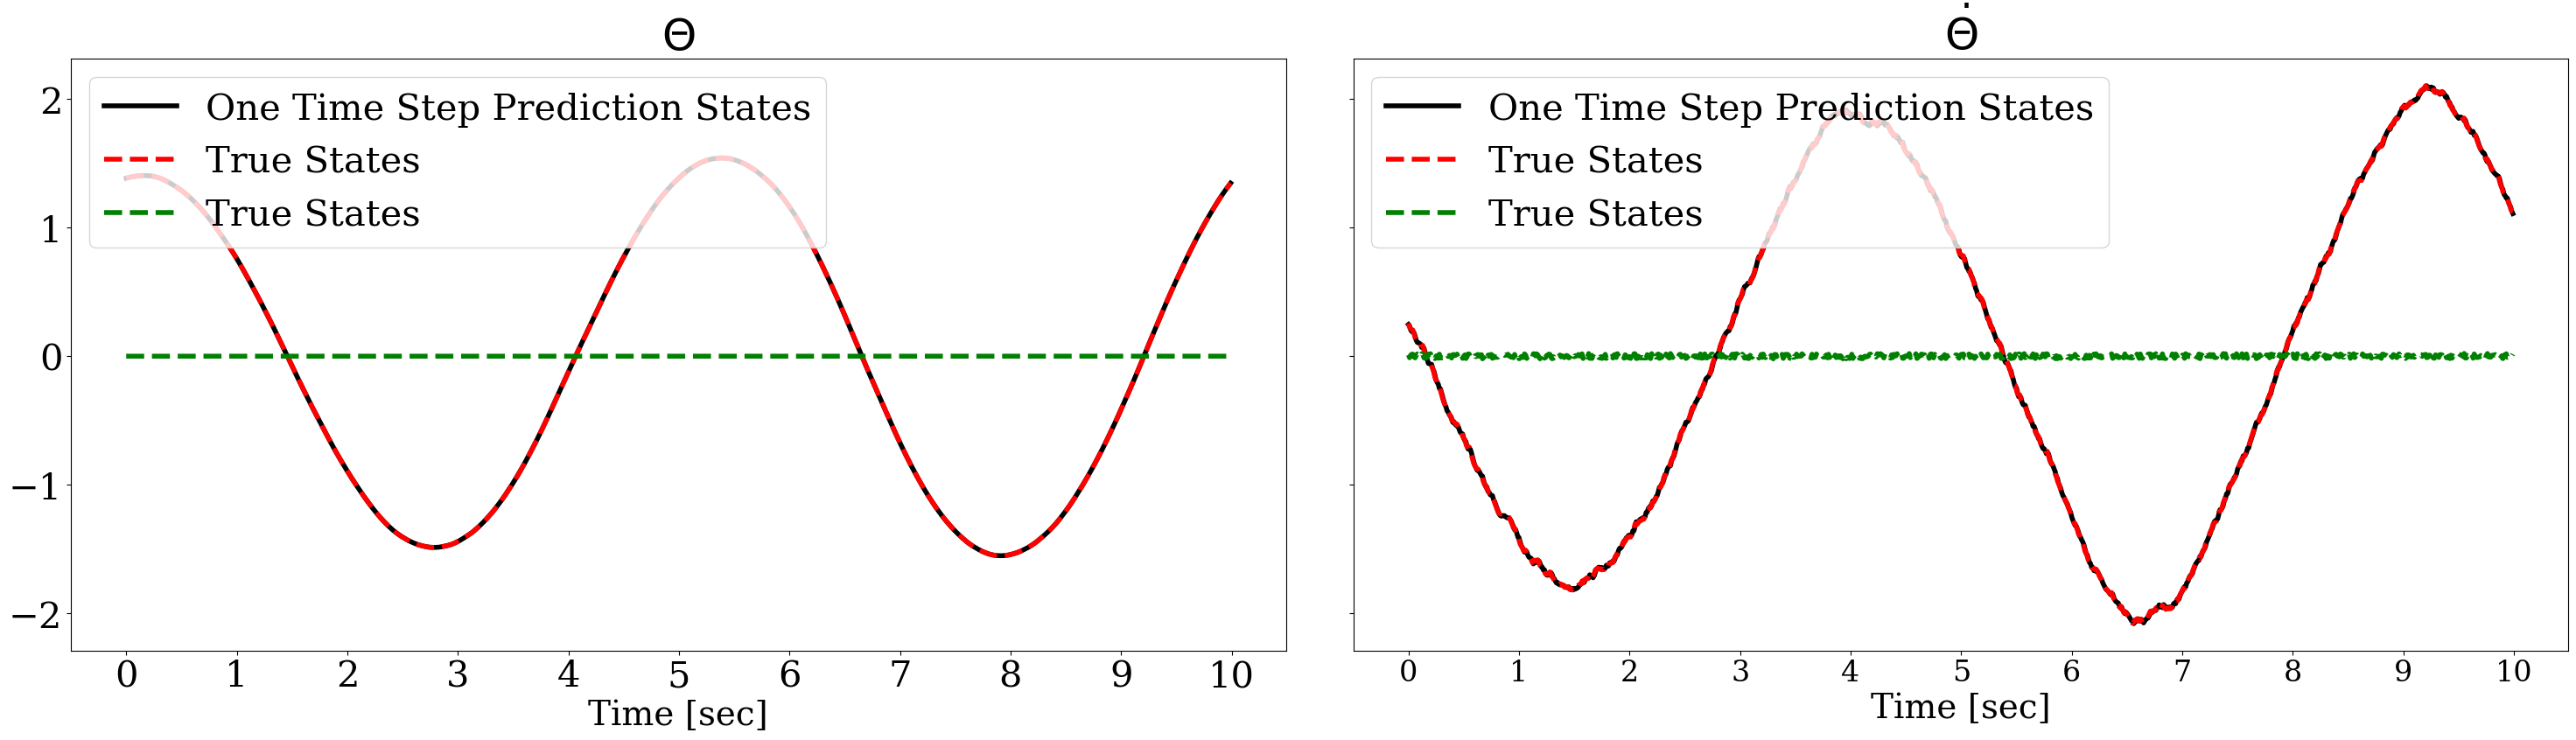

In [10]:
x_init=2*torch.Tensor(2).uniform_(-1, 1) # random initial condition
tf = 10 # simulation time
dp = int(tf/dt) # number of data points

time = np.linspace(0, tf, dp+1) # time vector
xk = x_init 
sol = np.empty([nx,]) # initializing matrix to hold solution

# Nonlinear solution from equations of motion
for t in time:
    uk = 2*torch.Tensor(1).uniform_(-1, 1)
    sol = np.vstack((sol, xk))
    xk = rk4(pendfunc, t, xk,uk, dt) # RK4 approximation of solution

# splitting nonlinear solution into current and next timestep
sol = torch.FloatTensor(sol)
newx = sol[1:-1,:]
newy = sol[2:,:]

# observables for current and next time step
new_phi = torch.transpose(modelen(newx.to(device)),0,1)
new_phi = torch.cat((torch.transpose(newx.to(device),0,1),new_phi.to(device)),0).cpu()
new_phi_p1 = torch.matmul(K_best.cpu(),new_phi)

# Plotting results
kp1_plot = torch.transpose(newy,0,1)
fig, ax = plt.subplots(1, 2, sharex = 'col', sharey = 'row', figsize = (30, 8))
fig.tight_layout(pad = 3.0)
colours = ['black', 'red']
line = ['-', '--']
plot_lines = []
error = kp1_plot - new_phi_p1[0:2,:]
for i in range(2):
    p1, = ax[i].plot(new_phi_p1[i,:].detach(), color=colours[0], linestyle=line[0], label='One Time Step Prediction States', linewidth=4)
    p2, = ax[i].plot(kp1_plot[i,:].detach(), color=colours[1], linestyle=line[1], label='True States', linewidth=4)
    p3, = ax[i].plot(error[i,:].detach(), color='green', linestyle=line[1], label='True States', linewidth=4)
    ax[i].legend(loc=2, fontsize=30)
    ax[i].set_xticks([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], fontsize=24)
    ax[i].set_xlabel("Time [sec]", fontsize = 28)
#     plot_lines.append([p1, p2])
# legend1 = ax.legend(plot_lines[0], ['Exact Solution', 'Proposed Solution'], fontsize=30, loc=4)
# ax.add_artist(legend1)
# ax.legend([p[0] for p in plot_lines], ['$\Theta$', '$\dot{\Theta}$'], loc=2, fontsize=30)
ax[0].set_ylabel('', fontsize = 22)
ax[0].tick_params(labelsize=30)
ax[0].set_title("$\Theta$", fontsize=36)
ax[1].set_title("$\dot{\Theta}$", fontsize=36)

Text(0.5, 1.0, '$\\dot{\\Theta}$')

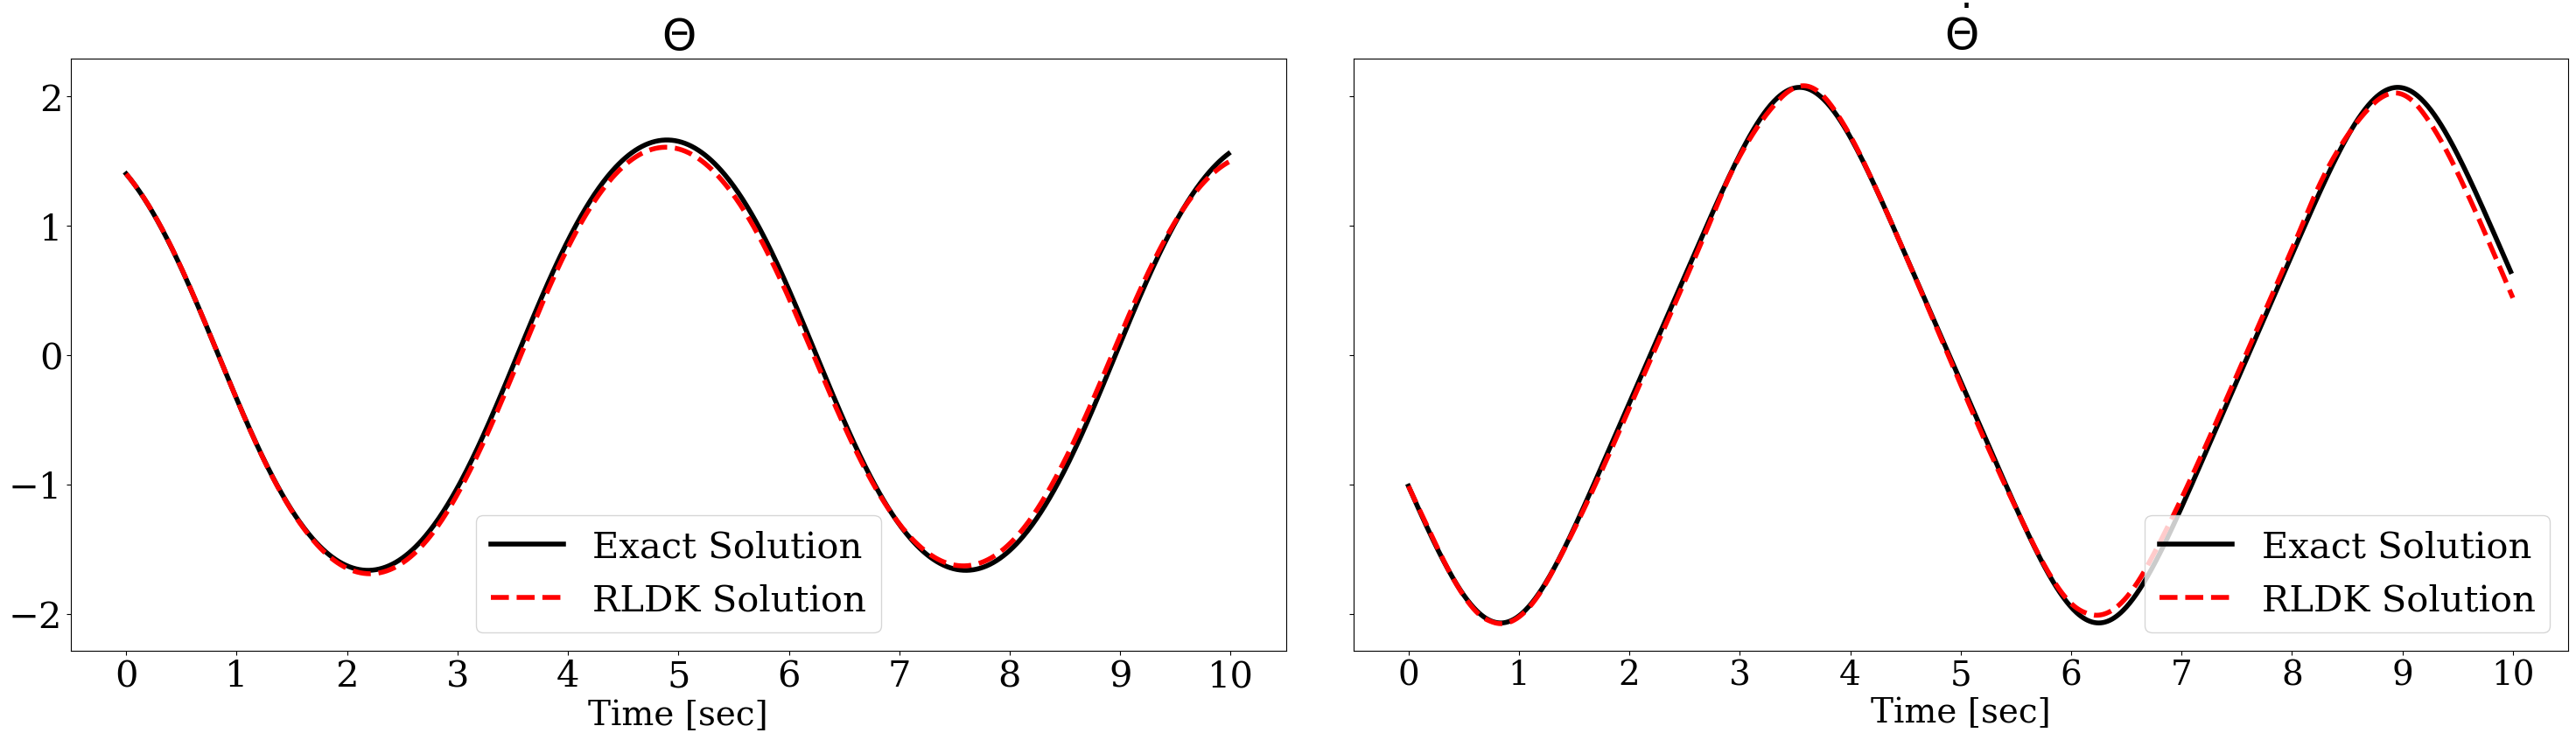

In [11]:
# x_init=2*torch.Tensor(1,2).uniform_(-1, 1) + (0.001**0.5)*torch.rand(2) # random initial condition with noise
x_init = torch.tensor([[1.4021,-1.0130]]) # same initial condition as autoencoder model

# observable of the initial condition and stacking original states on observable
x_init_encoded = torch.transpose(modelen(x_init.to(device)),0,1)
x_in = torch.cat((torch.transpose(x_init.to(device),0,1),x_init_encoded),0).cpu()

time = np.linspace(0,10,1000) # time vector

# initializing vectors
new_states = torch.clone(torch.transpose(x_init,0,1))
save_u = np.empty([m,])
xk = torch.tensor([x_init[0,0], x_init[0,1]])
sol = np.empty([nx,])

# simulation
i = 0
for t in time:
    u_dt = 0*torch.Tensor(1,1).uniform_(-1, 1) # random control input
    save_u = np.vstack((save_u, u_dt)) # saving control history
    next_phi = torch.matmul(K_best.cpu(),x_in).cpu() + torch.matmul(B_best.cpu(),u_dt).cpu() # linear dynamics with Koopman matrices
    next_state = torch.matmul(P.cpu(),next_phi).cpu() # correction step
    next_state_encoded = torch.transpose(modelen(torch.transpose(next_state,0,1).to(device)),0,1) # lifting the next state for next iteration
    next_phi = torch.cat((next_state.to(device),next_state_encoded),0).cpu() # stacking original state on observables
    x_in = next_phi # reinitializing for next iteration
    new_states = torch.hstack([new_states, next_state]).cpu() # saving solution history
    i = i+1

    # nonlinear solution
    uk = u_dt[0]
    sol = np.vstack((sol, xk))
    xk = rk4(pendfunc, t, xk, uk, dt)

sol = torch.FloatTensor(sol)
newx = torch.transpose(sol[1:-1,:],0,1)

# Plotting
fig, ax = plt.subplots(1, 2, sharex = 'col', sharey = 'row', figsize = (30, 8))
fig.tight_layout(pad = 3.0)
colours = ['black', 'red','deepskyblue']
line = ['-', '--',':']
plot_lines = []
for i in range(2):
    p1, = ax[i].plot(newx[i,:].detach(), color=colours[0], linestyle=line[0], label='Exact Solution', linewidth=4)
    p2, = ax[i].plot(new_states[i,:].detach(), color=colours[1], linestyle=line[1], label='RLDK Solution', linewidth=4)
    ax[i].set_xticks([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], fontsize=28)
    ax[i].set_xlabel("Time [sec]", fontsize = 28)
    ax[i].legend(fontsize=30)
    # plot_lines.append([p1, p2])
# legend1 = ax.legend(plot_lines[0], ['Exact Solution', 'RLDK Solution'], fontsize=30, loc=4)
# ax.add_artist(legend1)
# ax.legend([p[0] for p in plot_lines], ['$\Theta$', '$\dot{\Theta}$'], loc=2, fontsize=30)
ax[0].set_ylabel('', fontsize = 22)
ax[0].tick_params(labelsize=30)
ax[0].set_title("$\Theta$", fontsize=36)
ax[1].set_title("$\dot{\Theta}$", fontsize=36)

# ***Error in Proposed Solution***

Text(0.5, 1.0, 'Error in Proposed Solution for $\\Theta$ and $\\dot{\\Theta}$')

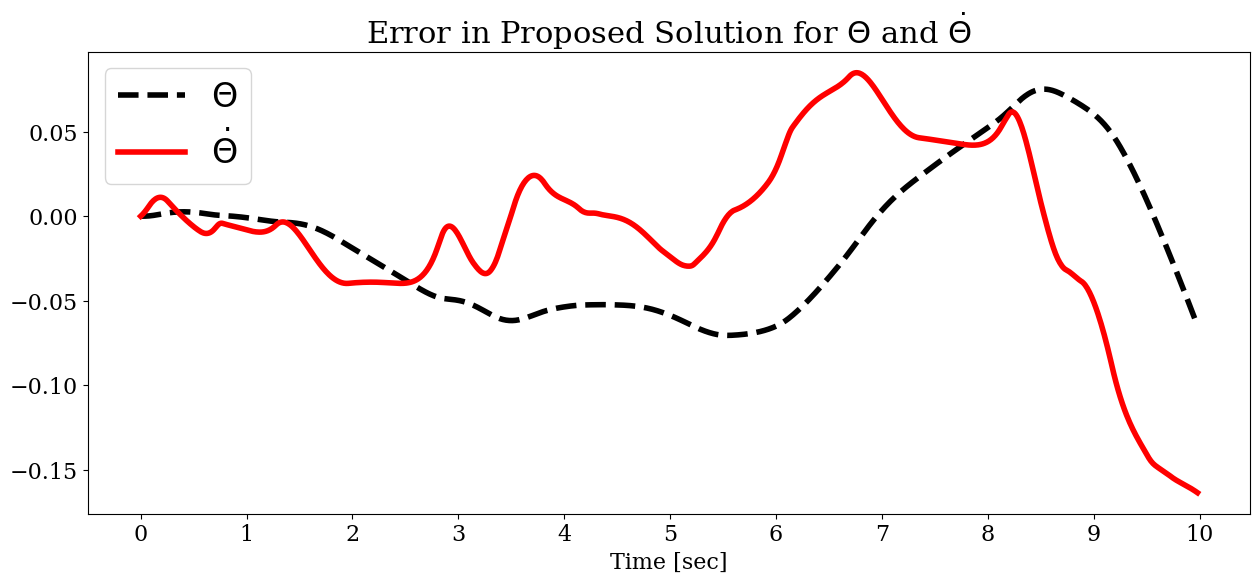

In [12]:
error_phi = new_states[:,:999] - newx # error between linear and nonlinear solutions

# Plotting 
plt.figure(figsize = (15, 6))
ax = plt.axes()
colours = ['black', 'red','deepskyblue']
line = ['--','-']
labels = ['$\Theta$', '$\dot{\Theta}$']
for i in range(2):
    ax.plot(error_phi[i,:].detach(), color=colours[i], linestyle=line[i], label=labels[i], linewidth=4)
    ax.legend(fontsize=24)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.xticks([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.xlabel("Time [sec]", fontsize=16)
plt.title("Error in Proposed Solution for $\Theta$ and $\dot{\Theta}$", fontsize=22)

# ***Comparison with Autoencoder Model***

Text(0.5, 1.0, 'Comparison of models for $\\Theta$ and $\\dot{\\Theta}$')

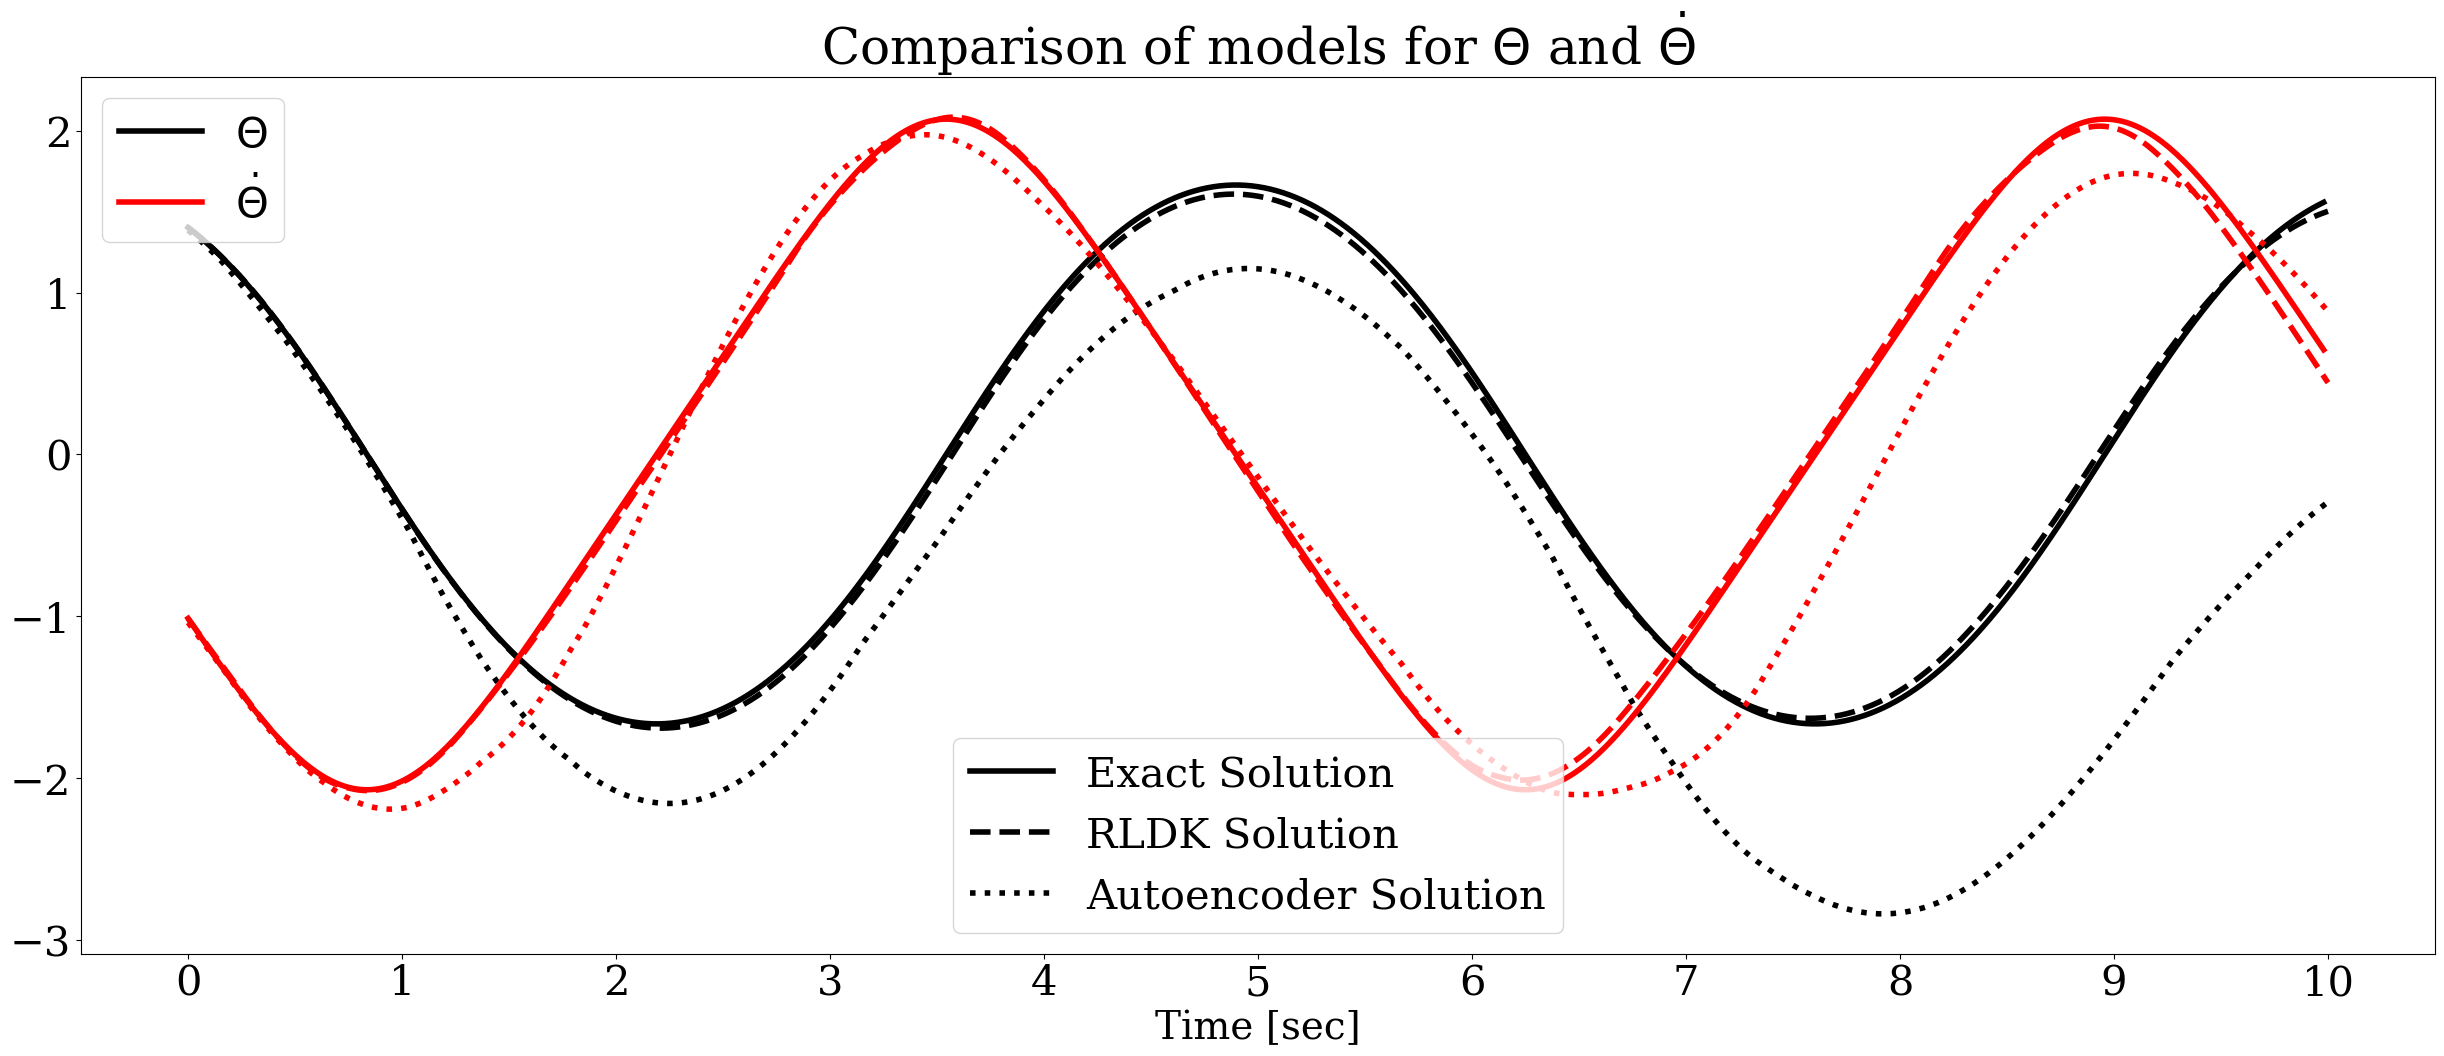

In [13]:
# loading Autoencoder model
with open('decoder_state.pkl', 'rb') as f:
    decoder_states = pickle.load(f)

# x_init=2*torch.Tensor(1,2).uniform_(-1, 1) + (0.001**0.5)*torch.rand(2) # random initial condition with noise
x_init = torch.tensor([[1.4021,-1.0130]]) # same initial condition as autoencoder model

# observable of the initial condition and stacking original states on observable
x_init_encoded = torch.transpose(modelen(x_init.to(device)),0,1)
x_in = torch.cat((torch.transpose(x_init.to(device),0,1),x_init_encoded),0).cpu()

time = np.linspace(0,10,1000) # time vector

# initializing vectors
new_states = torch.clone(torch.transpose(x_init,0,1))
save_u = np.empty([m,])
xk = torch.tensor([x_init[0,0], x_init[0,1]])
sol = np.empty([nx,])

# simulation
i = 0
for t in time:
    u_dt = 0*torch.Tensor(1,1).uniform_(-1, 1) # no control input (Autoencoder model was not built with control)
    save_u = np.vstack((save_u, u_dt)) # saving control history
    next_phi = torch.matmul(K_best.cpu(),x_in).cpu() + torch.matmul(B_best.cpu(),u_dt).cpu() # linear dynamics with Koopman matrices
    next_state = torch.matmul(P.cpu(),next_phi).cpu() # correction step
    next_state_encoded = torch.transpose(modelen(torch.transpose(next_state,0,1).to(device)),0,1) # lifting the next state for next iteration
    next_phi = torch.cat((next_state.to(device),next_state_encoded),0).cpu() # stacking original state on observables
    x_in = next_phi # reinitializing for next iteration
    new_states = torch.hstack([new_states, next_state]).cpu() # saving solution history
    i = i+1

    # nonlinear solution
    uk = u_dt[0]
    sol = np.vstack((sol, xk))
    xk = rk4(pendfunc, t, xk, uk, dt) # RK4 approximation of solution

sol = torch.FloatTensor(sol)
newx = torch.transpose(sol[1:-1,:],0,1)

# Plotting
fig, ax = plt.subplots(1, 1, sharex = 'col', sharey = 'row', figsize = (25, 10))
fig.tight_layout(pad = 3.0)
colours = ['black', 'red', 'dodgerblue']
state = ['$\Theta$', '$\dot{\Theta}$']
line = ['-', '--',':']
plot_lines = []
for i in range(2):
    p1, = ax.plot(newx[i,:].detach(), color=colours[i], linestyle=line[0], label='Exact Solution', linewidth=4)
    p2, = ax.plot(new_states[i,:].detach(), color=colours[i], linestyle=line[1], label='RLDK Solution', linewidth=4)
    p3, = ax.plot(decoder_states[i,:].detach(), color=colours[i], linestyle=line[2], label='Autoencoder Solution', linewidth=4)
    ax.set_xticks([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], fontsize=28)
    ax.set_xlabel("Time [sec]", fontsize = 28)
    plot_lines.append([p1, p2, p3])
legend1 = ax.legend(plot_lines[0], ['Exact Solution', 'RLDK Solution', 'Autoencoder Solution'], fontsize=30, loc=8)
ax.add_artist(legend1)
ax.legend([p[0] for p in plot_lines], ['$\Theta$', '$\dot{\Theta}$'], loc=2, fontsize=30)
ax.set_ylabel('', fontsize = 22)
ax.tick_params(labelsize=30)
ax.set_title("Comparison of models for $\Theta$ and $\dot{\Theta}$", fontsize=36)


# **Error Plotting**

Text(0.5, 1.0, 'Absolute Error comparison in $\\Theta$ and $\\dot{\\Theta}$')

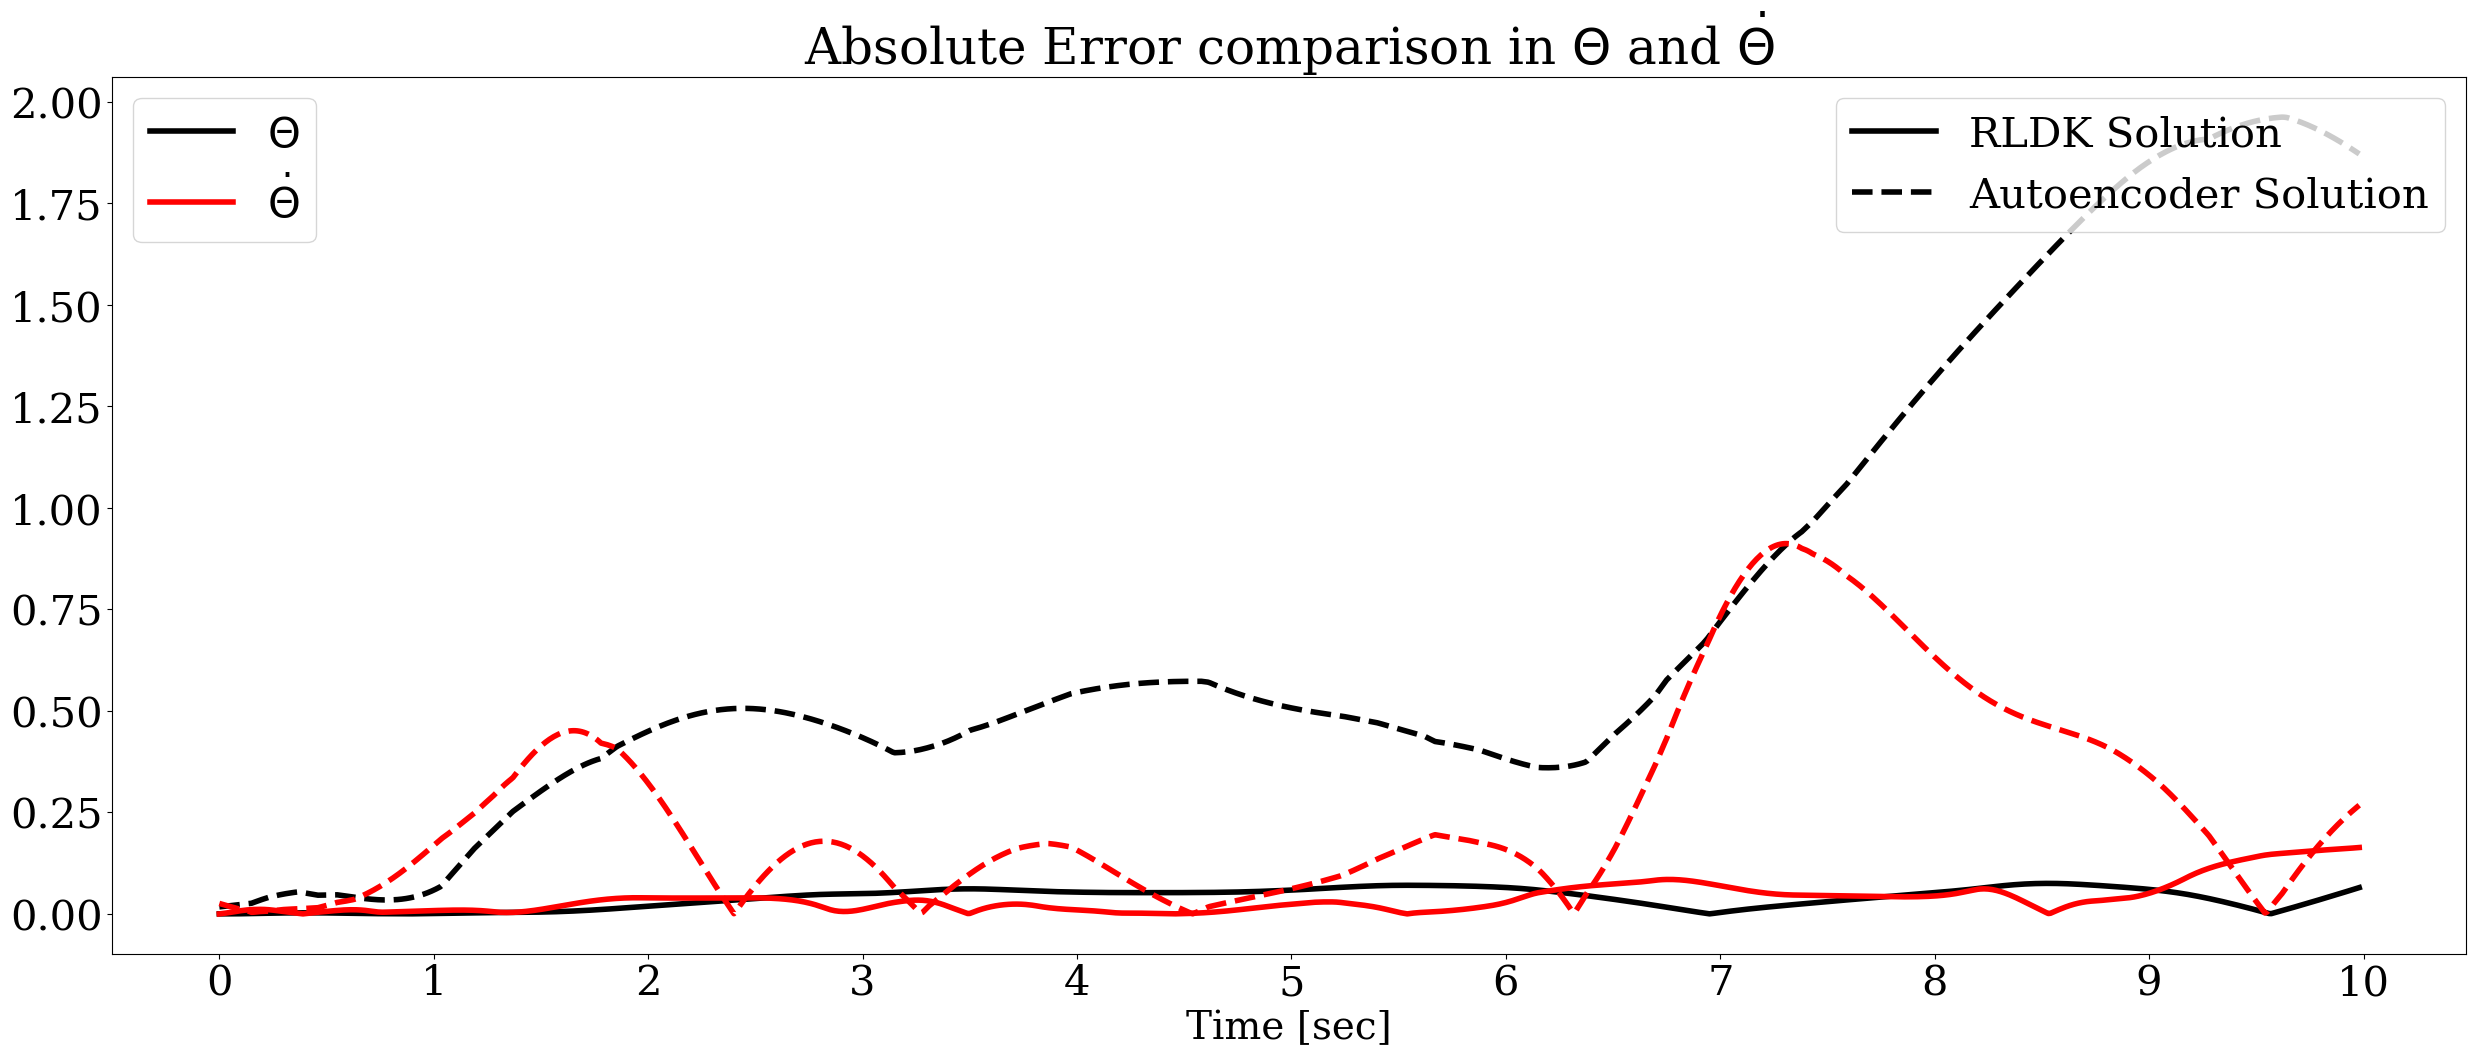

In [14]:
error_phi_new = torch.abs(new_states[:,:999] - newx) # error for proposed model
error_phi_old = torch.abs(decoder_states[:,:999] - newx) # error for autoencoder model

# Plotting
fig, ax = plt.subplots(1, 1, sharex = 'col', sharey = 'row', figsize = (25, 10))
fig.tight_layout(pad = 3.0)
colours = ['black', 'red','dodgerblue']
line = ['-', '--',':']
error_lines = []
for i in range(2):
    p1, = ax.plot(error_phi_new[i,:].detach(), color=colours[i], linestyle=line[0], label='RLDK Solution', linewidth=4)
    p2, = ax.plot(error_phi_old[i,:].detach(), color=colours[i], linestyle=line[1], label='Autoencoder Solution', linewidth=4)
    ax.set_xticks([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], fontsize=28)
    ax.set_xlabel("Time [sec]", fontsize = 28)
    error_lines.append([p1, p2])
legend1 = ax.legend(error_lines[0], ['RLDK Solution', 'Autoencoder Solution'], fontsize=30, loc=1)
ax.add_artist(legend1)
ax.legend([p[0] for p in error_lines], ['$\Theta$', '$\dot{\Theta}$'], loc=2, fontsize=30)
ax.set_ylabel('', fontsize = 22)
ax.tick_params(labelsize=30)
ax.set_title("Absolute Error comparison in $\Theta$ and $\dot{\Theta}$", fontsize=36)

### *Controls*

In [15]:
A = (K_best.cpu()-torch.eye(lifted_space+nx))/dt
A = A.detach().numpy()
B_copy = B_best.cpu().detach().clone().numpy()/dt
# B_copy = np.array([0,1,0,0]).reshape(-1,1)

Q = np.eye(lifted_space+nx)
# Q[0,0] = 1
# Q[1,1] = 1
Q[2,2] = 0
Q[3,3] = 0
R = 1

K_gain, S, E = ct.lqr(A, B_copy, Q, R)
K_gain = torch.FloatTensor(K_gain)

### *LQR developed in Python (Not as good)*

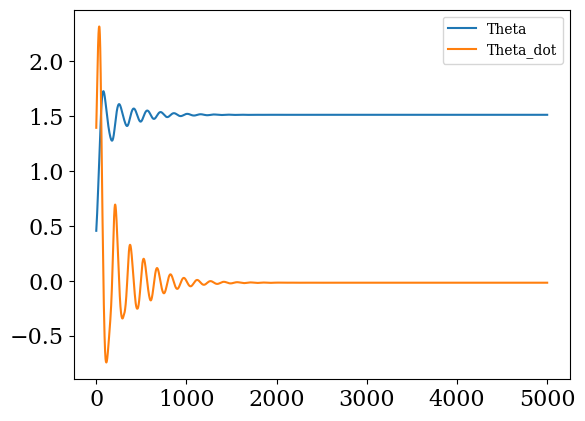

In [16]:
# initial condition
x_init=2*torch.Tensor(1,2).uniform_(-1, 1)# + (0.001**0.5)*torch.rand(2)

x_init_encoded = torch.transpose(modelen(x_init.to(device)),0,1)
x_in = torch.cat((torch.transpose(x_init.to(device),0,1),x_init_encoded),0).cpu()

time = np.linspace(0,50,5000) # simulate for dp=1000 data points

new_states = torch.clone(torch.transpose(x_init,0,1))
save_u = np.empty([m,])
i = 0
A = torch.Tensor(A)
B_copy = torch.Tensor(B_copy)
for t in time:
    u_dt = -torch.matmul(K_gain,x_in).detach()
    save_u = np.vstack((save_u, u_dt))
    next_phi = torch.matmul(K_best.cpu(),x_in).cpu() + torch.matmul(B_best.cpu(),u_dt).cpu()
    next_state = torch.matmul(P.cpu(),next_phi).cpu()
    new_states = torch.hstack([new_states, next_state]).cpu()
    next_state_encoded = torch.transpose(modelen(torch.transpose(next_state,0,1).to(device)),0,1)
    next_phi = torch.cat((next_state.to(device),next_state_encoded),0).cpu()
    x_in = next_phi
    i = i+1

plt.plot(new_states[0,:].detach(), label='Theta')
plt.plot(new_states[1,:].detach(), label='Theta_dot')
plt.legend()

# ***LQR Controller***

Text(0.5, 1.0, 'LQR Control Response for $\\Theta$ and $\\dot{\\Theta}$')

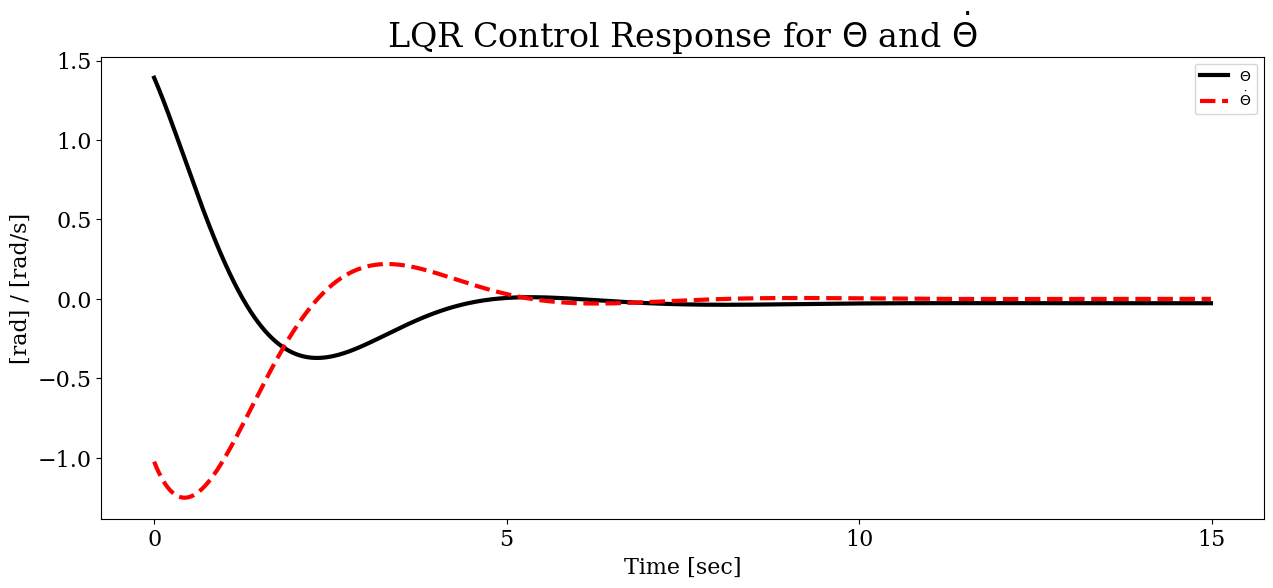

In [17]:
# importing state history from LQR controlled system built in MATLAB
df = pd.read_csv('LQR_data.csv').to_numpy()
t = np.linspace(0,15, 1500)

# plotting
plt.figure(figsize = (15, 6))
ax = plt.axes()
colour = ['black', 'red']
line = ['-', '--']
labels = ['$\Theta$', '$\dot{\Theta}$']
for i in range(2):
    ax.plot(df[:1500,i], linestyle = line[i], color = colour[i], label = labels[i], linewidth=3)
    ax.legend(fontsize=10)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.xticks([0, 500, 1000, 1500],[0, 5, 10, 15])
plt.xlabel("Time [sec]", fontsize=16)
plt.ylabel("[rad] / [rad/s]", fontsize=16)
plt.title("LQR Control Response for $\Theta$ and $\dot{\Theta}$", fontsize=24)